## mac OS 세팅

In [3]:
# %pip install opencv-python

In [4]:
# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7680)]  # 7.5GB
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# 메모리 정리 콜백
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

Metal device set to: 1 Physical GPUs, 1 Logical GPUs
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-07-10 12:57:09.995182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 12:57:09.995909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Simple CNN 만들기

In [5]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [6]:
# image resizing, 리스트에 집어넣고, split
def load_all_data(base_dir, img_size=(299, 299)):
    images = [] 
    labels = []
    
    categories = ['NORMAL', 'COVID19'] # 카테고리 분류(3-4개면 3~4개의 카테고리 써넣기)
    
    for category in categories: #폴더안의 폴더에 들어가기 위해 루프 3번 돌림
        class_num = categories.index(category) #ls.index(data) -> 리스트 안에 data의 index 값을 반환
        for subset in ['train', 'test', 'val']:
            subset_dir = os.path.join(base_dir, subset, category) #root/datasets/pneumonia  /train  /normal
            for img in os.listdir(subset_dir):
                try:
                    img_path = os.path.join(subset_dir, img) # image 파일의 경로
                    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #image array로 불러오기
                    new_array = cv2.resize(img_array, img_size) # img_size에 맞춰서 크기 조정
                    images.append(new_array) #data 다 불러와서 image 라는 리스트에 다 모으고 있음
                    labels.append(class_num)
                except Exception as e:
                    print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

def split_data(X, y, test_size=0.2, val_size=0.2):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size / (1 - test_size), stratify=y_train_val, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
base_dir = "COVID-19" 
X, y = load_all_data(base_dir,)
#X에는 내가 다운 받은 영상값 y는 정답값

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) 
#함수 생성시 기본 값을 적어놨기 때문에 특별한 값을 입력하지 않으면 기본값을 따른다.

print(f"Train data shape : {X_train.shape}, Train labels shape : {y_train.shape}")
print(f"Val data shape : {X_val.shape}, Val labels shape : {y_val.shape}")
print(f"Test data shape : {X_test.shape}, Test labels shape : {y_test.shape}")

Train data shape : (1295, 299, 299), Train labels shape : (1295,)
Val data shape : (432, 299, 299), Val labels shape : (432,)
Test data shape : (432, 299, 299), Test labels shape : (432,)


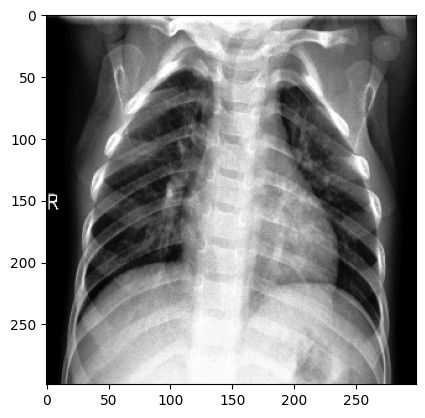

In [8]:
def he_img(image) :
    return cv2.equalizeHist(image)

equalized_img = he_img(X_train[708])
plt.imshow(equalized_img, cmap='gray')
plt.show()

In [9]:
def create_simple_cnn(input_shape): # 함수 정의
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 필터 수: 32, 합성곱 층 추가, 3x3
        MaxPooling2D((2, 2)), # 최대 층 추가, 2x2
        Conv2D(64, (3, 3), activation='relu'), # 필터 수: 64, 합성공 층 추가, 3x3
        MaxPooling2D((2, 2)), # 최대 층 추가, 2x2
        Conv2D(64, (3, 3), activation='relu'), # 필터 수: 64, 합성곱 층 추가, 3x3
        Flatten(), # 1차원 배열로 전환
        Dense(64, activation='relu'), # 64개 뉴런을 가진 완전 연결 계층 추가
        Dense(1, activation='sigmoid') # 1개 뉴런을 가진 출력 층 추가
        #sigmoid : 이진 함수 binary, 하나에 대한 예측값만 출력하면 됨, 여러개면 Dense(2,activation='softmax').model.compile(~~~,loss='sparse_crossentropy')
    ])
    return model

In [10]:
# 모델 컴파일을 위해!
input_shape = (299, 299, 1) #resize 값과 동일하게, 1은 채널값 (gray=1)

model = create_simple_cnn(input_shape) # 함수를 이용해서 모델 구축

model.compile(optimizer='adam', ## 옵티마이저 모델로 Adam 사용
              loss='binary_crossentropy', #sigmoid를 썼으니 손실 함 수 사용
              metrics=['accuracy']) # 평가를 accuracy를 이용해 처리

# 특정 조건을 만족하면 자동으로 만료
early_stopping = EarlyStopping(
    monitor='val_loss',# 검증 데이터셋의 정확도 모니터링
    patience=10, #10번 동안 val_loss가 변화가 없는 것 같다면 멈춤 # 정체가 왔을 때 스탑하는걸 방지하려면 patience 값 바꾸면 됨
    verbose=1, #결과값 출력
    mode='min',# 최저를 기준으로 저장
    restore_best_weights=True # 가장 좋은 가중치 저장
)
# 가중치 모니터
model_checkpoint = ModelCheckpoint(
    'best_model.h5',# 모델을 저장할 파일 경로
    monitor='val_accuracy',# 검증 데이터셋의 정확도 모니터링
    mode='max', # accuracy max값 확인
    verbose=1, # 결과값 출력
    save_best_only=True# 가장 성능이 좋았던 모델 저장
)
# early stop, model_check point -> overfitting 방지
model.summary()
#input shape을 봐야 하고, output shape을 활용해 pooling이 제대로 되고 있는지 확인해야 함

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

In [11]:
history = model.fit( #훈련데이터 fit시키기
    X_train, y_train, #fit 시킬 데이터
    validation_data=(X_val, y_val), # 짝 지어주기
    epochs=100, #100번 돌아가여~, 그 동안 성능 좋은게 나오면 stop. earliystop과 checkpoint 설정을 안 하면 overfitting 생길 수 있음.
    batch_size=32, #전체 이미지 사이즈를 32만큼 나눔 메모리가 넘 부담되면 batch size 줄임
    callbacks=[early_stopping, model_checkpoint] # early_stopping과 model_checkpoint를 callbacks에 저장
)

model = tf.keras.models.load_model('best_model.h5') #가중치 값 저장하는 확장명

Epoch 1/100


2024-07-10 12:57:31.045288: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-10 12:57:31.487074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s - loss: 60.9264 - accuracy: 0.7977

2024-07-10 12:57:44.516110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.88889, saving model to best_model.h5
41/41 [==============================] - 15s 347ms/step - loss: 60.9264 - accuracy: 0.7977 - val_loss: 0.3287 - val_accuracy: 0.8889
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.9251
Epoch 2: val_accuracy improved from 0.88889 to 0.89815, saving model to best_model.h5
41/41 [==============================] - 14s 348ms/step - loss: 0.2991 - accuracy: 0.9251 - val_loss: 0.5283 - val_accuracy: 0.8981
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.9236
Epoch 3: val_accuracy improved from 0.89815 to 0.90972, saving model to best_model.h5
41/41 [==============================] - 15s 366ms/step - loss: 0.3726 - accuracy: 0.9236 - val_loss: 0.3072 - val_accuracy: 0.9097
Epoch 4/100
41/41 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9490
Epoch 4: val_accuracy improved from 0.90972 to 0.93981, saving

In [12]:
test_los, test_acc = model.evaluate(X_test, y_test) # model의 손실 값과 정확도 계산
print(f"Test Accuracy : {test_acc : 4f}") # test data에 대한 정확도를 소수점 4자리까지 출력

2024-07-10 13:01:57.641978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 105ms/step - loss: 0.2625 - accuracy: 0.9537
Test Accuracy :  0.953704


In [13]:
y_pred = model.predict(X_test)# 테스트 데이터셋에 대해 모델을 사용하여 예측 수행
y_pred_classes = (y_pred>0.5).astype(int).flatten() # 예측된 확률을 이진 클래스 레이블로 변환,

 1/14 [=>............................] - ETA: 2s

2024-07-10 13:01:59.796668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 96ms/step


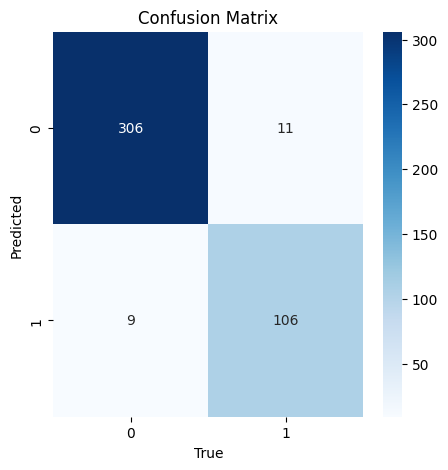

In [14]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5)) #그래프의 사이즈(가로, 세로)를 조절함. 단위는 inch
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues' )#빈도수 높을수록 색 찐해짐 heatmap
plt.title("Confusion Matrix") # 그래프 제목: Confusion Matrix
plt.xlabel('True') # x축 label: True
plt.ylabel('Predicted') # y축 label: Predicted
plt.show() # 그래프를 화면에 출력

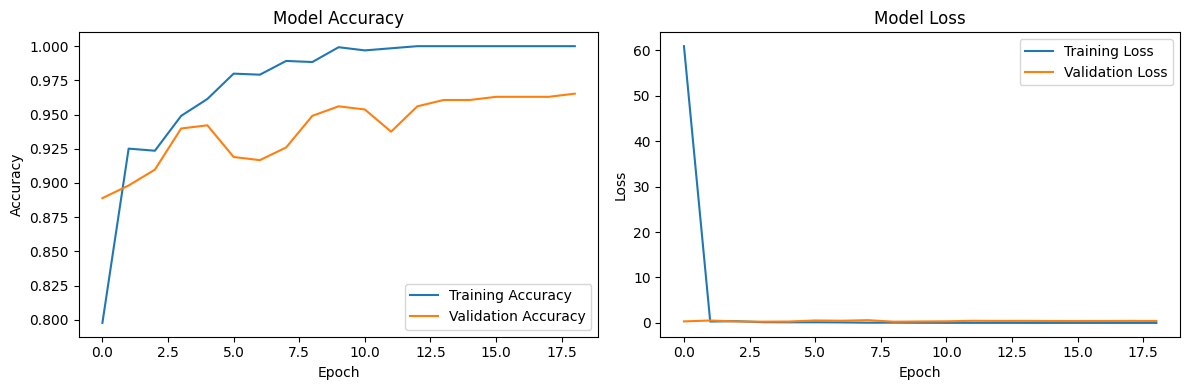

In [15]:
plt.figure(figsize=(12, 4))                                              # 가로 12, 세로 4인 그림 생성
plt.subplot(1, 2, 1)                                                     # subplot의 index는 1부터 2,3,4... 순으로 진행됨 
                                                                         # (0부터 시작되는 파이썬의 인덱싱과 다른 방식임)
plt.plot(history.history['accuracy'], label='Training Accuracy')         # 훈련 정확도 변화를 나타내는 그래프 생성
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')   # 검증 정확도 변화를 나타내는 그래프 생성
plt.title('Model Accuracy')                                              # 그래프 제목: Model Accuracy
plt.xlabel('Epoch')                                                      # x축 label: Epoch
plt.ylabel('Accuracy')                                                   # y축 label: Accuracy
plt.legend()                                                             # 범례 추가

plt.subplot(1, 2, 2)                                                     # 두 개의 subplot중 두번째 subplot 설정
plt.plot(history.history['loss'], label='Training Loss')                 # 훈련 손실 변화를 나타내는 그래프 생성
plt.plot(history.history['val_loss'], label='Validation Loss')           # 검증 손실 변화를 나타내는 그래프 생성
plt.title('Model Loss')                                                  # 그래프 제목: Model Loss
plt.xlabel('Epoch')                                                      # x축 label: Epoch
plt.ylabel('Loss')                                                       # y축 label: Loss
plt.legend()                                                             # 범례 추가

plt.tight_layout() # 간격 조정
plt.show()         # 그래프 보여주삼

## Inception 테스트

#### 데이터 불러오기

In [16]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
#전체 데이터 불러오고 전처리하는 함수 만들기
def load_and_preprocess_data(base_dir, img_size=(299, 299)): # load_and_preprocess_data 정의
    images = [] # image data를 모으는 빈 리스트 생성
    labels = [] # lable data를 모으는 빈 리스트 생성
    categories = ['COVID', 'NORMAL'] # 카테고리 분류 (3~4개면 3~4개의 카테고리 써넣기)

    for category in categories: # category 반복
        class_num = categories.index(category) # categorry의 class_num 가져오기
        base_path = os.path.join(base_dir, category) # path는 접근 경로, base_path 생성
        base_files = os.listdir(base_path) # base_files 가져오기
        # print(base_files)
        np.random.shuffle(base_files) # base_files 랜덤 재배치
        for idx in range(500): # 임의로 500개의 데이터를 섞어 그 중 일부만 쓰려고 함
          image_path = os.path.join(base_path, base_files[idx]) # base_path 생성 후 이미지 파일 불러오기
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # (경로, 스케일)
          image = cv2.resize(image, img_size) # (이미지, 이미지 사이즈)
          images.append(image) # images 리스트에 image 추가
          labels.append(class_num) # labels 리스트에 class_num 추가

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1) #-1 : 갯수만큼 다 집어넣어라 / imgae size는 그대로, ims_size[1] = gray scale(1개)
    return images, np.array(labels) #list를 array로 변환

def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42) # 전체 데이터를 train과 val_test로 나누기
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=val_size, stratify=y_val_test, random_state=42) # val_size 비율에 따라 다시 train과 val_test로 나누기
    return X_train, y_train, X_val, y_val, X_test, y_test
    #stratify : class 비율을 맞춰서 분할해준다 (normal과 pneumonia)

In [18]:
base_dir = "COVID-19" 
X, y = load_all_data(base_dir,)
#X에는 내가 다운 받은 영상값 y는 정답값

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) 
#함수 생성시 기본 값을 적어놨기 때문에 특별한 값을 입력하지 않으면 기본값을 따른다.

print(f"Train data shape : {X_train.shape}, Train labels shape : {y_train.shape}")
print(f"Val data shape : {X_val.shape}, Val labels shape : {y_val.shape}")
print(f"Test data shape : {X_test.shape}, Test labels shape : {y_test.shape}")

Train data shape : (1727, 299, 299), Train labels shape : (1727,)
Val data shape : (216, 299, 299), Val labels shape : (216,)
Test data shape : (216, 299, 299), Test labels shape : (216,)


#### 환경 구성

In [19]:
# 환경 구성
from tensorflow.keras.applications import InceptionV3 #사전학습된 inception v3의 가중치로 내 데이터를 학습한다. pretrained model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [20]:
def create_inceptionv3_model(input_shape): # InceptionV3 모델 생성
    base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=input_shape) # InceptionV3 모델 불러오기
    # include_top : 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    base_model.trainable = False # 가중치 고정

    # 완전 연결 계층(inference)
    x = base_model.output # 베이스 모델에서 특징 추출
    x = GlobalAveragePooling2D()(x) # Global Average Pooling
    x = Dense(1024, activation='relu')(x) # 완전 연결 계층
    output = Dense(1, activation='sigmoid')(x) # 출력 계층

    model = Model(inputs=base_model.input, outputs=output) # 모델 생성
    return model # 모델 반환

In [21]:
X_train_rgb = np.repeat(X_train, 3, axis=-1) # 데이터 차원을 rgb 채널에 있는 것 처럼 확장
X_val_rgb = np.repeat(X_val, 3, axis=-1) # 데이터 차원을 rgb 채널에 있는 것 처럼 확장
X_test_rgb = np.repeat(X_test, 3, axis=-1) # 데이터 차원을 rgb 채널에 있는 것 처럼 확장

# Inception 모델용 전처리
X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train_rgb)  # Inception 모델의 전처리 함수 적용
X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val_rgb)  # 검증 데이터에 전처리 함수 적용
X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test_rgb)  # 테스트 데이터에 전처리 함수 적용

model = create_inceptionv3_model((299, 299, 3)) # 모델 생성
model.compile(optimizer=Adam(learning_rate=0.0001), # 구성에 대한 부분 집어넣기
              loss='binary_crossentropy', # sigmoid와 세트
              metrics=['accuracy']) # 정확도 출력

callbacks = [ # 오버피팅 방지, 가장 좋은 성능의 모델값만 나타나게 하기 위함
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), # 검증 손실이 10번의 에포크 동안 개선되지 않으면 학습 조기 종료, 최상의 가중치 복원
    tf.keras.callbacks.ModelCheckpoint('best_inception_model.h5', save_best_only=True)  # 가장 좋은 성능의 모델을 'best_inception_model.h5' 파일에 저장
]

In [22]:
history = model.fit( # 모델학습 시작 , history 객체 학습 결과 저장
    X_train_preprocessed, y_train, # 학습에 사용할 훈련 데이터와 레이블
    validation_data=(X_val_preprocessed, y_val), # 검증 데이터
    epochs=50, # 100번 돌림
    batch_size=32, # 32씩 묶음
    callbacks=callbacks # 오버피팅 방지, 가장 좋은 성능의 모델값만 나타나게 하기 위함
)

Epoch 1/50


ValueError: in user code:

    File "/opt/miniconda3/envs/esg/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/opt/miniconda3/envs/esg/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/miniconda3/envs/esg/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/opt/miniconda3/envs/esg/lib/python3.8/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/opt/miniconda3/envs/esg/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/miniconda3/envs/esg/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 299, 897)


In [ ]:
model = tf.keras.models.load_model('best_inception_model.h5') # 가중치 값을 저장, 학습 후 가장 높은 성능을 나타낸 가중치를 불러오기